In [ ]:
# -------------------- Imports --------------------
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import random
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
import warnings
import json
import pandas as pd

In [ ]:
# ------------------ Bước 1: Đọc CSV ------------------
def load_urls_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    urls = [str(url).strip() for url in df["checked_url"]]
    return [{"checked_url": url} for url in urls]

In [ ]:
# ------------------ Bước 2: Crawl nội dung 1 trang ------------------
def fetch_content(url):
    try:
        resp = requests.get(url, timeout=5, headers={"User-Agent": "Mozilla/5.0"})
        if resp.status_code != 200:
            return None

        warnings.filterwarnings("ignore")
        soup = BeautifulSoup(resp.content, "html.parser")

        # Loại bỏ các tag không cần thiết
        for tag in soup(["script", "style", "noscript", "footer", "nav", "form", "button", "iframe"]):
            tag.extract()

        text = " ".join(soup.get_text().split())

        # Bỏ qua text quá ngắn hoặc lỗi
        if len(text) < 30 or any(err in text.lower() for err in ["error", "not found", "denied"]):
            return None

        return text[:5000]  # Giới hạn text
    except Exception as e:
        with open("error_urls.txt", "a", encoding="utf-8") as f:
            f.write(f"{url} | {str(e)}\n")
        return None

In [ ]:
# ------------------ Bước 3: Keyword gộp URL + text ------------------
keywords_dict = {
    "chính trị": ["quochoi","gov","chinhphu","nghiquyet","election","baocu","dang","party","canbo","politics",
                  "quốc hội","chính phủ","nghị quyết","bầu cử","dân chủ","vote","ứng cử","cơ quan nhà nước",
                  "luật","chính sách"],#chính trị
    "cờ bạc": ["casino","bet","xoso","nhacai","slot","poker","baccarat","jackpot","danhbac","wager",
               "cá cược","xổ số","nhà cái","đánh bạc","quay thưởng","vòng quay","trò chơi","đặt cược",
               "giải đấu","bonus"], #uy tín, game, bài
    "18+": ["phim18","jav","sex","nguoilon","erotic","porn","18plus","adult","hentai","sexvideo",
            "phim người lớn","xxx","khiêu dâm","video sex","người lớn","nude","quan hệ","sexmovie","adultfilm","pornstar"]
}

In [ ]:
# ------------------ Bước 4: Gán label ------------------
def assign_label(url, text, keywords_dict):
    url_lower = url.lower()
    text_lower = text.lower()

    match_count = {}
    for topic, kws in keywords_dict.items():
        match_count[topic] = sum(1 for kw in kws if kw.lower() in url_lower or kw.lower() in text_lower)

    max_count = max(match_count.values())
    if max_count == 0:
        return "nội dung khác"

    candidates = [topic for topic, count in match_count.items() if count == max_count]
    return candidates[0]

In [ ]:
# ------------------ Bước 5: Crawl đa luồng + gán label ------------------
def crawl_and_label(urls_with_labels, max_workers=50):
    results = []

    def worker(item):
        text = fetch_content(item["checked_url"])
        if text:
            label = assign_label(item["checked_url"], text, keywords_dict)
            # Tìm các keyword xuất hiện
            keywords_found = [kw for kw in sum(keywords_dict.values(), []) if kw.lower() in text.lower() or kw.lower() in item["checked_url"].lower()]
            return {
                "url": item["checked_url"],
                "label": label,
                "text": text,
                "keywords_found": list(set(keywords_found))  # unique
            }
        return None

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(worker, item) for item in urls_with_labels]
        for future in futures:
            res = future.result()
            if res:
                results.append(res)

    return results

In [ ]:
# ------------------ Crawl theo batch ------------------
def crawl_all(urls_with_labels, batch_size=5000, max_workers=200):
    all_results = []
    for i in range(0, len(urls_with_labels), batch_size):
        batch = urls_with_labels[i:i+batch_size]
        print(f"Crawl batch {i//batch_size + 1}: {len(batch)} URLs")
        batch_results = crawl_and_label(batch, max_workers=max_workers)
        all_results.extend(batch_results)
    return all_results

In [ ]:
# ------------------ Bước 6: Lưu JSON ------------------
def save_to_json(data, filename="dataset.json"):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

In [ ]:
# ------------------ Run pipeline ------------------
if __name__ == "__main__":
    csv_path = "rules_20250303_classified.csv"
    df = pd.read_csv(csv_path)
    urls_with_labels = [{"checked_url": str(url).strip()} for url in df["checked_url"]]

    dataset = crawl_all(urls_with_labels, batch_size=5000, max_workers=200)

    with open("dataset.json", "w", encoding="utf-8") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=2)

    print(f"Crawl xong, lưu {len(dataset)} mẫu vào dataset.json")

In [ ]:
# -------------------- Load dataset --------------------
with open("dataset.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Ghép text + keywords_found (list -> string) để làm input
texts = []
labels = []
for item in data:
    text_part = item.get("text", "")
    kw_part = " ".join(item.get("keywords_found", [])) if isinstance(item.get("keywords_found"), list) else str(item.get("keywords_found"))
    combined_text = f"{item['url']} {text_part} {kw_part}"
    texts.append(combined_text)
    labels.append(item["label"])

# Ánh xạ label
label2id = {"chính trị":0, "cờ bạc":1, "18+":2, "nội dung khác":3}
id2label = {v:k for k,v in label2id.items()}
y = [label2id[lbl] for lbl in labels]

In [ ]:
# ==================== PHÂN BỐ BAN ĐẦU ====================
label_counts = pd.Series(labels).value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Phân bố nhãn ban đầu")
plt.show()

In [ ]:
# ==================== STRATIFIED SPLIT ====================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)
print("Train size:", len(train_texts), "| Val size:", len(val_texts))

In [ ]:
# ==================== OVERSAMPLING ====================
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
train_counts = train_df["label"].value_counts()
max_count = train_counts.max()

balanced_dfs = []
for lbl in train_counts.index:
    df_class = train_df[train_df["label"] == lbl]
    df_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
    balanced_dfs.append(df_resampled)

train_df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Final data
train_texts = train_df_balanced["text"].tolist()
train_labels = train_df_balanced["label"].tolist()

In [ ]:
# ==================== TOKENIZATION ====================
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# ==================== TORCH DATASET ====================
from torch.utils.data import Dataset
class TopicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TopicDataset(train_encodings, train_labels)
val_dataset   = TopicDataset(val_encodings, val_labels)

In [ ]:
# ==================== CLASS WEIGHTS ====================
orig_counts = Counter(train_labels)
weights = [1.0 / orig_counts.get(i,1) for i in range(len(label2id))]
class_weights = torch.tensor(weights, dtype=torch.float)

In [ ]:
# ==================== MODEL ====================
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# ==================== METRICS ====================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [26]:
# ==================== TRAINING ARGS ====================
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [ ]:
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        # **kwargs sẽ nhận bất kỳ tham số thừa nào (như num_items_in_batch)
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [42]:
# ==================== TRAIN ====================
trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    compute_loss_func=compute_loss)
trainer.train()


--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\logging\__init__.py", line 1154, in emit
    stream.write(msg + self.terminator)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1252.py", line 19, in encode
    return codecs.charmap_encode(input,self.errors,encoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeEncodeError: 'charmap' codec can't encode character '\u1ecb' in position 807: character maps to <undefined>
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.sta

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.026100,0.211975,0.965727,0.966501
2,0.022400,0.195516,0.973064,0.973060
3,0.000100,0.238652,0.973273,0.973258


TrainOutput(global_step=20757, training_loss=0.044624984437677366, metrics={'train_runtime': 45106.8463, 'train_samples_per_second': 7.363, 'train_steps_per_second': 0.46, 'total_flos': 4.39939921784832e+16, 'train_loss': 0.044624984437677366, 'epoch': 3.0})

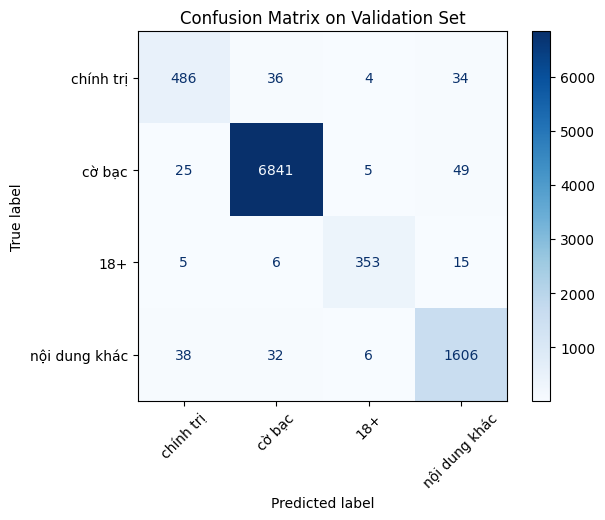

In [43]:
# ==================== CONFUSION MATRIX ====================
preds = trainer.predict(val_dataset)
y_true = val_labels
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix on Validation Set")
plt.show()

In [ ]:
# ==================== ĐÁNH GIÁ ====================
print("\n------ Classification Report ------")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(label2id.keys()),
    digits=4
))


------ Classification Report ------
               precision    recall  f1-score   support

    chính trị     0.8773    0.8679    0.8725       560
       cờ bạc     0.9893    0.9886    0.9889      6920
          18+     0.9592    0.9314    0.9451       379
nội dung khác     0.9425    0.9548    0.9486      1682

     accuracy                         0.9733      9541
    macro avg     0.9421    0.9357    0.9388      9541
 weighted avg     0.9733    0.9733    0.9733      9541



In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

# Chọn checkpoint cuối cùng
checkpoint_path = "./results/checkpoint-20757"

# Load model từ checkpoint (safetensors tự nhận)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint_path)

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Lưu lại toàn bộ model + tokenizer
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json',
 'saved_model\\tokenizer.json')